## Real Estate Price Prediction
### Geekbrains AI/BigData Python for Data Science course competition

In [1]:
import gc # сборщик мусора

import numpy as np 
import pandas as pd 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from lightgbm import LGBMRegressor


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import warnings
warnings.filterwarnings('ignore')

###  1. Data loading

#### Data fields
- Id - apartment identification number
- DistrictId - district identification number
- Rooms - number of rooms
- Square - apartment area
- LifeSquare - living area of apartment
- KitchenSquare - kitchen area 
- Floor - apartment floor
- HouseFloor - the number of floors of a building
- HouseYear - Building year of completion
- Ecology_1, Ecology_2, Ecology_3 - environmental indicators of the area
- Social_1, Social_2, Social_3 - social indicators of the area
- Healthcare_1, Helthcare_2 - healthcare indicators of the area
- Shops_1, Shops_2 - indicators related to the presence of shops, shopping centers

In [2]:
df = pd.read_csv('C:/Users/ASER/Desktop/GeekBrains/ML_libraries/kaggle_project/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('C:/Users/ASER/Desktop/GeekBrains/ML_libraries/kaggle_project/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('X.shape:', X.shape)
print('X_final.shape', X_final.shape)

# Удалим ненужные файлы
#del df
gc.collect()  

X.shape: (10000, 18)
X_final.shape (5000, 18)


0

In [3]:
X.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B


### Exploratory Data Analysis

### A. Target tariable distribution

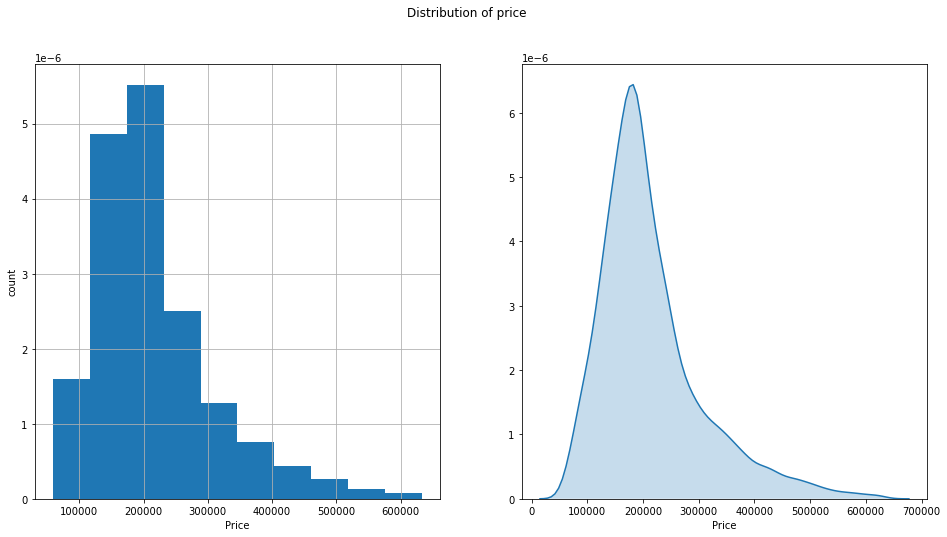

In [4]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=True)  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(y['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

In [5]:
target_mean = y['Price'].mean()
target_median = y['Price'].median()
target_mode = y['Price'].mode()[0]

print('target_mean = ', target_mean.round())
print('target_median = ', target_median.round())
print('target_mode = ', target_mode.round())

target_mean =  214139.0
target_median =  192270.0
target_mode =  59175.0


### B. Feature analysis

In [6]:
X.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

#### 1. Rooms

In [7]:
X['Rooms'].value_counts()
# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

#### 2. Square,  LifeSquare

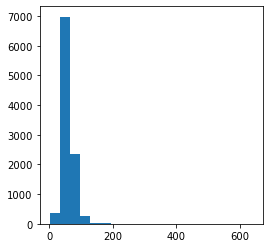

In [8]:
X.loc[X['Square'] > 0, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [9]:
X[X.Square < 13].Square.sort_values(ascending=False)

Id
1748     5.497061
9487     5.129222
13265    4.823679
11526    4.633498
7657     4.502784
4504     4.390331
10527    4.380726
6782     2.954309
10202    2.596351
3224     2.377248
15744    1.988943
14786    1.136859
Name: Square, dtype: float64

In [10]:
X[X.Square > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [11]:
X[X.LifeSquare > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B


In [12]:
(X['Square'] < X['LifeSquare']).sum()

482

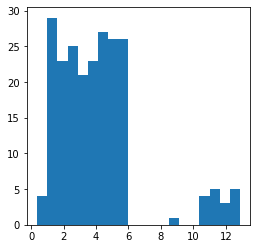

In [13]:
X.loc[X.LifeSquare < 13, 'LifeSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [14]:
X[X.LifeSquare < 10]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A
4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B
12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,27,2.0,58.943039,3.319486,1.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B
2040,62,1.0,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
13630,24,3.0,127.141143,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B


#### 3. KitchenSquare

In [15]:
X['KitchenSquare'].value_counts().sort_values(ascending=False)

# Площадь < 3
# Площадь > 1000

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
37.0         2
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
32.0         2
58.0         2
30.0         2
53.0         1
63.0         1
31.0         1
123.0        1
73.0         1
23.0         1
29.0         1
21.0         1
26.0         1
75.0         1
36.0         1
1970.0       1
39.0         1
62.0         1
42.0         1
84.0         1
27.0         1
78.0         1
60.0         1
35.0         1
2014.0       1
40.0         1
48.0         1
66.0         1
96.0         1
72.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [16]:
# Площадь кухни больше половины площади квартиры
X[X['KitchenSquare'] > X.Square * 0.5].KitchenSquare.count()

34

#### 4. HouseFloor, Floor

In [17]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [18]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [19]:
(X['Floor'] > X['HouseFloor']).sum()

1825

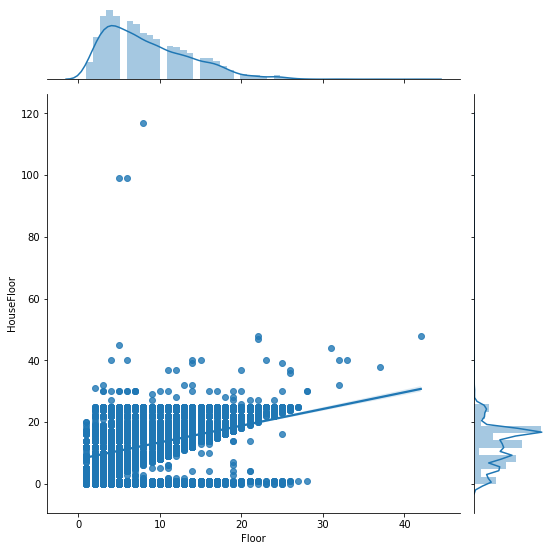

In [20]:
grid = sns.jointplot(X['Floor'], X['HouseFloor'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [21]:
X[X.HouseFloor > 50]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B
9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


#### 5. HouseYear

In [22]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [23]:
X[X['HouseYear'] > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


#### Missing data

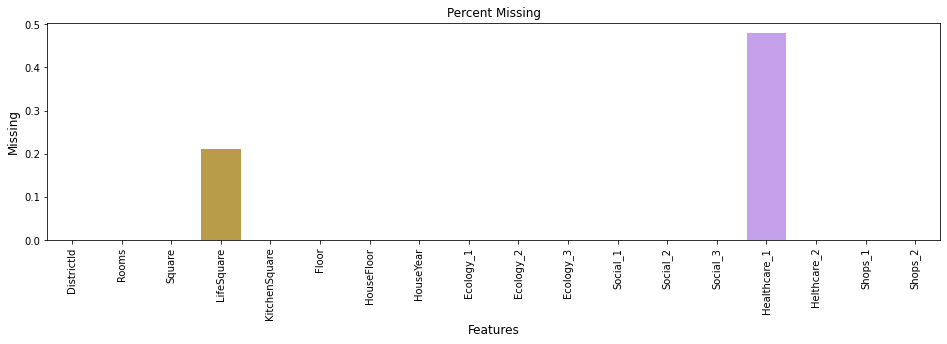

In [24]:
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Drop Healthcare_1
# Replace NaN values in LifeSquare

### C. Feature engineering

#### 1. DistrictId

In [25]:
X.DistrictId.nunique()

205

In [26]:
dict(X['DistrictId'].value_counts())

{27: 851,
 1: 652,
 23: 565,
 6: 511,
 9: 294,
 62: 247,
 30: 228,
 58: 179,
 53: 174,
 21: 165,
 52: 143,
 8: 142,
 11: 129,
 46: 119,
 61: 118,
 45: 116,
 74: 114,
 34: 111,
 57: 107,
 44: 104,
 99: 97,
 101: 97,
 47: 97,
 13: 97,
 7: 92,
 48: 90,
 29: 89,
 94: 89,
 41: 87,
 3: 82,
 84: 80,
 28: 79,
 2: 78,
 22: 78,
 25: 77,
 85: 76,
 93: 73,
 37: 72,
 90: 72,
 96: 71,
 59: 67,
 75: 66,
 26: 65,
 12: 64,
 88: 64,
 128: 64,
 66: 62,
 67: 61,
 17: 59,
 55: 58,
 39: 57,
 10: 56,
 105: 55,
 31: 55,
 18: 51,
 111: 49,
 119: 49,
 0: 48,
 78: 46,
 91: 44,
 124: 43,
 63: 43,
 129: 43,
 42: 42,
 79: 42,
 109: 41,
 113: 41,
 77: 40,
 54: 37,
 15: 36,
 38: 36,
 24: 35,
 5: 34,
 56: 34,
 32: 34,
 103: 33,
 123: 32,
 19: 31,
 80: 31,
 33: 31,
 83: 31,
 69: 29,
 138: 29,
 130: 29,
 64: 28,
 108: 27,
 86: 27,
 70: 27,
 87: 27,
 120: 26,
 122: 25,
 100: 25,
 121: 25,
 20: 24,
 89: 24,
 107: 23,
 35: 22,
 169: 22,
 98: 21,
 167: 20,
 144: 20,
 145: 19,
 146: 18,
 81: 18,
 134: 18,
 73: 17,
 36: 17,
 

#### 2. Ecology_1

In [27]:
X.Ecology_1.nunique()

129

In [28]:
dict(X['Ecology_1'].value_counts())

{0.007122317: 587,
 0.0: 537,
 0.243204519: 511,
 0.072157581: 486,
 0.075778755: 346,
 7.81528e-05: 245,
 0.069753361: 204,
 0.161531741: 202,
 0.034656082000000005: 190,
 0.090799103: 176,
 0.211401214: 172,
 0.371148999: 163,
 0.041116354: 151,
 0.049637257: 148,
 0.017647053: 142,
 0.011654127: 141,
 0.43788524: 137,
 0.195781053: 128,
 0.300322518: 117,
 0.118537385: 110,
 0.194489265: 103,
 0.033493708: 99,
 0.006076152: 99,
 0.13321533300000002: 95,
 0.041124634: 89,
 0.127375905: 89,
 0.050900058: 87,
 0.069660344: 86,
 0.019508796: 84,
 0.037177818: 84,
 0.225824954: 83,
 6.99893e-05: 83,
 0.111627393: 79,
 0.265088676: 78,
 0.158249043: 78,
 0.012338886: 76,
 0.309479124: 75,
 0.135649789: 73,
 0.000995363: 71,
 0.130617806: 71,
 0.122090347: 70,
 0.00016967599999999998: 70,
 0.319809354: 67,
 0.458174486: 67,
 0.282797669: 66,
 0.089039719: 66,
 0.307466659: 65,
 0.0077202819999999985: 64,
 0.038692987000000005: 63,
 0.100455735: 62,
 0.188783766: 62,
 0.151346216: 62,
 0.03

#### 3. Social_1

In [29]:
X.Social_1.nunique()

51

In [30]:
dict(X['Social_1'].value_counts())

{2: 688,
 1: 654,
 25: 557,
 5: 528,
 30: 465,
 23: 434,
 6: 377,
 22: 367,
 53: 355,
 34: 311,
 33: 252,
 46: 245,
 31: 243,
 43: 238,
 9: 213,
 36: 209,
 21: 207,
 37: 205,
 24: 205,
 52: 201,
 0: 201,
 35: 200,
 47: 177,
 74: 176,
 39: 159,
 27: 151,
 28: 144,
 4: 141,
 11: 138,
 42: 129,
 26: 127,
 16: 123,
 19: 118,
 66: 99,
 17: 96,
 49: 95,
 18: 92,
 32: 87,
 41: 83,
 50: 79,
 29: 70,
 38: 64,
 8: 62,
 15: 51,
 20: 50,
 14: 46,
 10: 24,
 13: 22,
 12: 18,
 7: 15,
 3: 9}

#### 4. Social_2

In [31]:
X.Social_2.nunique()

142

In [32]:
dict(X['Social_2'].value_counts())

{264: 587,
 1564: 511,
 629: 486,
 1437: 346,
 6398: 245,
 13670: 204,
 5648: 202,
 168: 190,
 19083: 176,
 1892: 172,
 7065: 163,
 14892: 151,
 7759: 148,
 469: 142,
 915: 141,
 5735: 137,
 5212: 128,
 10311: 117,
 6207: 110,
 8004: 103,
 10573: 99,
 5285: 99,
 11395: 95,
 9515: 89,
 8429: 89,
 10621: 87,
 6119: 86,
 7687: 84,
 11217: 84,
 6558: 83,
 10309: 83,
 6714: 79,
 12238: 79,
 5731: 78,
 5288: 78,
 5776: 76,
 7715: 75,
 11319: 74,
 7960: 73,
 10418: 71,
 7651: 71,
 5992: 70,
 6566: 70,
 4439: 67,
 4756: 67,
 7976: 66,
 8667: 66,
 5048: 65,
 4788: 64,
 6533: 63,
 5562: 63,
 6137: 62,
 7227: 62,
 5889: 62,
 5487: 61,
 3889: 60,
 5613: 60,
 4378: 60,
 10055: 60,
 3893: 59,
 4798: 59,
 9292: 58,
 5011: 58,
 5664: 58,
 388: 56,
 475: 55,
 3097: 55,
 6564: 54,
 7614: 54,
 4346: 52,
 3806: 51,
 2787: 51,
 5469: 50,
 5027: 49,
 3594: 49,
 5569: 49,
 7077: 49,
 6141: 47,
 3478: 46,
 7010: 46,
 4472: 45,
 4789: 45,
 5261: 44,
 6856: 43,
 4635: 43,
 6746: 43,
 4625: 42,
 3433: 41,
 6783:

#### 5. Social_3

In [33]:
X.Social_3.nunique()

30

In [34]:
dict(X['Social_3'].value_counts())

{0: 2997,
 1: 1861,
 3: 1136,
 4: 835,
 2: 635,
 6: 423,
 5: 391,
 141: 245,
 9: 192,
 7: 184,
 11: 172,
 8: 170,
 10: 142,
 16: 101,
 14: 97,
 27: 59,
 48: 58,
 56: 49,
 84: 43,
 24: 37,
 87: 27,
 59: 25,
 93: 25,
 19: 22,
 20: 19,
 23: 18,
 39: 15,
 73: 10,
 45: 9,
 37: 3}

#### 6. Shops_1

In [35]:
X.Shops_1.nunique()

16

In [36]:
dict(X['Shops_1'].value_counts())

{0: 2316,
 1: 1325,
 5: 1324,
 2: 964,
 4: 841,
 3: 711,
 6: 487,
 11: 401,
 9: 316,
 7: 294,
 8: 253,
 23: 245,
 10: 215,
 15: 176,
 16: 83,
 19: 49}

## 2. Data cleaning

In [37]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.medians = None
        self.Square_medians = None        

        
    def fit(self, X):
        self.medians = X.median()
        self.Square_medians = X.groupby(['DistrictId', 'HouseYear','Rooms'])['Square'].median()        

    
    def transform(self, X):
        
        # Rooms        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[((X.Rooms < 4) | (X.KitchenSquare <=10)) & (X.Square > 250), 'Square'] /= 10
        X.loc[(X.Square < 13) & (X.LifeSquare > 13), 'Square'] = X[(X.Square < 13) & 
                                                                   (X.LifeSquare > 13)].LifeSquare
        for i in X[(X.Square < 13) | X.Square.isnull()].index:
            X.loc[i, 'Square'] = self.Square_medians[(X.loc[i, 'DistrictId'], 
                                                      X.loc[i, 'HouseYear'], 
                                                      X.loc[i, 'Rooms'])]
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3        
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] /= 10 
                
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna() | (X['LifeSquare'] < 8)) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
                
        return X

In [38]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

## 3. Feature engineering

In [39]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_ecology_1 = None
        self.med_price_by_social_2 = None        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]        
        self.DistrictId_counts = dict(district)
        
        # Ecology_1
        ecology_1 = X['Ecology_1'].value_counts()
        ecology_1 = ecology_1[ecology_1 > 50]        
        self.Ecology_1_counts = dict(ecology_1)        
                
        # Social_2
        social_2 = X['Social_2'].value_counts()
        social_2 = social_2[social_2 > 40]        
        self.Social_2_counts = dict(social_2)
        
      
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        
        
        # Target encoding
        ## 1. District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], 
                                                    as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
        ## 2. Ecology_1    
        if y is not None:
            df['Price'] = y.values            
            df['Ecology_1_frequent'] = df['Ecology_1'].copy()
            df.loc[~df['Ecology_1_frequent'].isin(ecology_1.keys().tolist())] = np.nan            
            self.med_price_by_ecology_1 = df.groupby(['Ecology_1_frequent', 'Rooms'], 
                                                     as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcology_1',
                                                           'Ecology_1_frequent': 'Ecology_1'})

        ## 3.Social_2
        if y is not None:
            df['Price'] = y.values            
            df['Social_2_frequent'] = df['Social_2'].copy()
            df.loc[~df['Social_2_frequent'].isin(social_2.keys().tolist())] = np.nan            
            self.med_price_by_social_2 = df.groupby(['Social_2_frequent', 'Rooms'], 
                                                    as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_2',
                                                          'Social_2_frequent': 'Social_2'})
        ## 4. floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], 
                                                      as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        
        # Dummy variables
        X = self.get_dummies(X)
        
        # PCA variables
        X = self.pca_features(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            
        if self.med_price_by_ecology_1 is not None:
            X = X.merge(self.med_price_by_ecology_1, on=['Ecology_1', 'Rooms'], how='left')
        
        if self.med_price_by_social_2 is not None:
            X = X.merge(self.med_price_by_social_2, on=['Social_2', 'Rooms'], how='left')
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            
                
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
               
    @staticmethod    
    def get_dummies(X):
        ## Helthcare_2
        X.loc[X.Helthcare_2 <= 1, 'Helthcare_2'] = 1    
        a = pd.get_dummies(X.Helthcare_2).rename(columns={1: 'H2_1', 2: 'H2_2', 3: 'H2_3', 
                                                          4: 'H2_4', 5: 'H2_5', 6: 'H2_6'})
        X = pd.concat([X, a], axis=1).drop('Helthcare_2', axis=1)
        
        
        ## clustered 'Square', 'LifeSquare', 'Rooms', 'KitchenSquare'
        scaler = StandardScaler()
        a = X[['Square', 'LifeSquare', 'Rooms', 'KitchenSquare']]
        a = scaler.fit_transform(a)
        kmeans = KMeans(n_clusters=6, random_state=0).fit(a)
        X.loc[:, 'Cluster_composit'] = kmeans.labels_
        
        a = pd.get_dummies(X.Cluster_composit).rename(columns={0: 'Cluster_1', 1: 'Cluster_2', 
                                                               2: 'Cluster_3', 3: 'Cluster_4', 
                                                               4: 'Cluster_5', 5: 'Cluster_6'})
        X = pd.concat([X, a], axis=1).drop('Cluster_composit', axis=1)
        
        return X
        
    @staticmethod   
    def pca_features(X):
        scaler = StandardScaler()
        a = X[['Square', 'LifeSquare', 'Rooms', 'KitchenSquare', 'HouseYear']].fillna(0)
        a = scaler.fit_transform(a)
        pca = PCA(n_components=2)
        pca.fit(a)    
        X.loc[:, 'pca_composit_1'] = np.dot(a, pca.components_.T)[:, 0]
        X.loc[:, 'pca_composit_2'] = np.dot(a, pca.components_.T)[:, 1]
    
        return X

In [40]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [41]:
X.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Shops_1',
 'Shops_2',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictId_count',
 'new_district',
 'floor_cat',
 'year_cat',
 'H2_1',
 'H2_2',
 'H2_3',
 'H2_4',
 'H2_5',
 'H2_6',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'pca_composit_1',
 'pca_composit_2',
 'MedPriceByDistrict',
 'MedPriceByEcology_1',
 'MedPriceBySocial_2',
 'MedPriceByFloorYear']

#### Removal of redundant and irrelevant data

In [42]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 
                   'Floor', 'HouseFloor', 
                   'HouseYear', 
                   'Ecology_1', 'Social_2',
                   'Shops_1',
                   
                   'Ecology_2', 'Ecology_3', 'Shops_2',
                   
                   'MedPriceByDistrict', 'DistrictId_count', 'LifeSquare_nan', 
                   'HouseFloor_outlier',                   
                                                     
                   'H2_1','H2_2','H2_3','H2_4','H2_5','H2_6',
                   'Cluster_1', 'Cluster_2', 'Cluster_3',
                   'Cluster_4', 'Cluster_5', 'Cluster_6']

X = X[remain_features]
X_final = X_final[remain_features]

## 4. Model

#### 1. LGBMRegressor

In [43]:
model = LGBMRegressor(max_depth=30, 
                             min_samples_leaf=10,
                             n_estimators=300, 
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.746 +- 0.014

R2: 0.746 +- 0.014


In [44]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

#### Feature_importances

In [45]:
feature_importances = pd.DataFrame(zip(X.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Square,0.157111
2,LifeSquare,0.130111
6,HouseYear,0.112222
8,Social_2,0.093111
13,MedPriceByDistrict,0.091111
7,Ecology_1,0.084778
4,Floor,0.068111
5,HouseFloor,0.063444
3,KitchenSquare,0.051000
14,DistrictId_count,0.042778


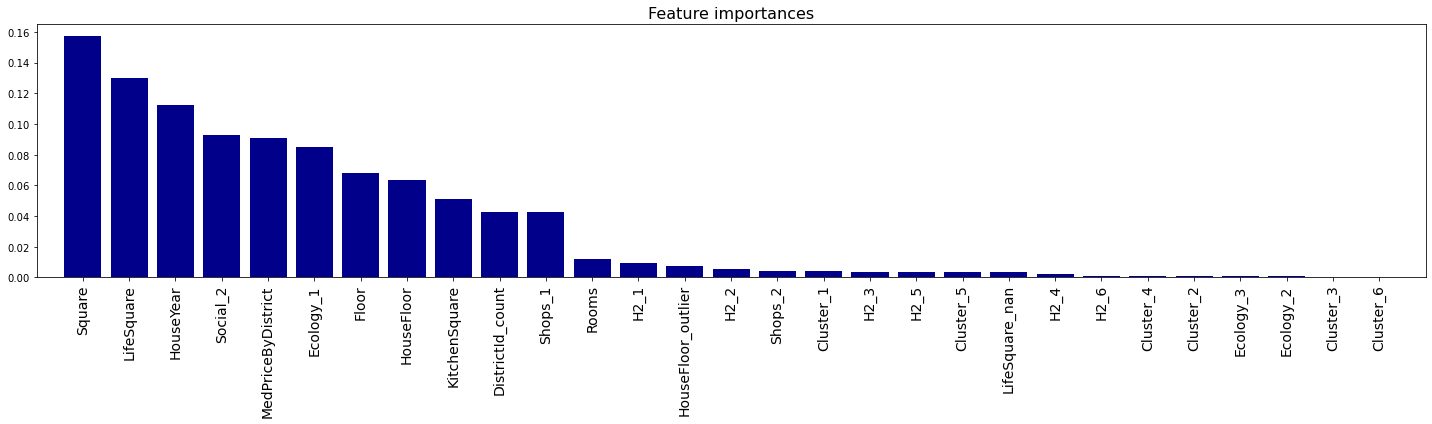

In [46]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

#### 2. RandomForestRegressor

In [47]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=15,  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                
                                n_estimators=400  
                                )
cv_score = cross_val_score(rf_model, X.fillna(0), y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.746 +- 0.014 - LGBMRegressor

R2: 0.693 +- 0.017


#### 3. VotingRegressor

In [48]:
v_model = VotingRegressor([('model', model), ('rf_model', rf_model)])

cv_score = cross_val_score(v_model, X.fillna(0), y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.746 +- 0.014 - LGBMRegressor

R2: 0.739 +- 0.017


### 5. Model hyperparameter tuning

#### 1. LGBMRegressor

In [49]:
lgb_model = LGBMRegressor(criterion='mse', 
                            min_samples_leaf=10,
                            random_state=42,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

In [50]:
params = {'n_estimators':[50, 100, 200, 300], 
          'max_depth':[7, 10, 15, 30, 40]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X, y)  

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [7, 10, 15,

In [51]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 200}

#### 2. RandomForestRegressor

In [52]:
rf_model = RandomForestRegressor(criterion='mse',                                  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                
                                #n_estimators=100  
                                )

In [53]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[7, 10, 15, 30]}

rf_gs = GridSearchCV(rf_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
rf_gs.fit(X.fillna(0), y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=30,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbos

In [54]:
rf_gs.best_params_

{'max_depth': 15, 'n_estimators': 400}

### 6. Final results

In [55]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,153689.178637
1,15856,262686.664419
2,5480,168715.594318
3,15664,323887.172818
4,14275,143423.606675


In [56]:
preds_final.shape

(5000, 2)